In [504]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
from torch import nn
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [93]:
class RandomFunction(nn.Module):
    def __init__(self):
        super(RandomFunction, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [94]:
rf = RandomFunction().cuda()

In [95]:
features = torch.randn(1000, 2).cuda()

In [98]:
data = rf(features).detach()

In [99]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 2)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [295]:
class Switch(nn.Module):
    def __init__(self):
        super(Switch, self).__init__()
        self.probas = nn.Parameter(torch.ones(50, requires_grad=True,
                                                         dtype=torch.float32) * 1.0)
        self.last_mask = None
    def clip_proba(self):
        self.probas.data = torch.clamp(self.probas.data, min=0.5, max=1.0)      
        
    def forward(self, x):
        self.clip_proba()
        
        mask = torch.bernoulli(self.probas.view(1, 50).repeat(x.shape[0], 1)).detach()
        self.last_mask = mask
        return torch.cat([mask, x * mask], dim=1)


In [296]:
sw(data)

tensor([[ 1.0000,  1.0000,  0.0000,  ...,  0.2010, -0.0000, -0.1472],
        [ 1.0000,  1.0000,  0.0000,  ...,  0.2824, -0.1426, -0.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.0749, -0.2973,  0.0255],
        ...,
        [ 0.0000,  1.0000,  1.0000,  ..., -0.0000, -0.0000,  0.1779],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000, -0.1497, -0.0722],
        [ 1.0000,  1.0000,  1.0000,  ..., -0.2950, -0.0000,  0.0000]],
       device='cuda:0')

In [297]:
dec = Decoder().cuda()
sw = Switch().cuda()

In [298]:
delta = (dec(sw(data)) - features).pow(2).sum(1)

In [299]:
def fill_probas_grad(delta):
    delta_view = delta.view(delta.shape[0], 1).repeat(1, 50)
    loss_on = torch.where(sw.last_mask > 0.5, delta_view, torch.zeros_like(delta_view)).sum(0)
    loss_off = torch.where(sw.last_mask < 0.5, delta_view, torch.zeros_like(delta_view)).sum(0)
    
    cnt_on = sw.last_mask.sum(0)
    cnt_off = (1 - sw.last_mask).sum(0)
    
    cnt_on = torch.clamp(cnt_on, 1, 100000000000000)
    cnt_off = torch.clamp(cnt_off, 1, 1000000000000)
    
    g = (loss_on / cnt_on - loss_off / cnt_off).detach()
    if sw.probas.grad is None:
        sw.probas.grad = g
    else:
        sw.probas.grad.data += g

In [300]:
opt = torch.optim.Adam(list(sw.parameters()) + list(dec.parameters()), lr=1e-3)

In [301]:
losses = []
fits = []
sparsity = []
coeffs = []
coeff = 1e-9

In [500]:
for i in tqdm(range(50000)):
    opt.zero_grad()
    delta = (dec(sw(data)) - features).pow(2).sum(1)
    loss_fit = delta.mean(0)
    
    if i % 50 == 0:
        if loss_fit < 1e-5 and coeff < 10:
            coeff /= 0.5
        elif coeff > 1e-9:
            coeff *= 0.5
    
    loss_sp = sw.probas.abs().sum()
    loss = loss_fit + loss_sp * coeff
    loss.backward()
    fill_probas_grad(delta)
    opt.step()
    
    losses.append(loss.item())
    fits.append(loss_fit.item())
    sparsity.append(loss_sp.item() - 0.5 * 50)
    coeffs.append(coeff)

KeyboardInterrupt: 

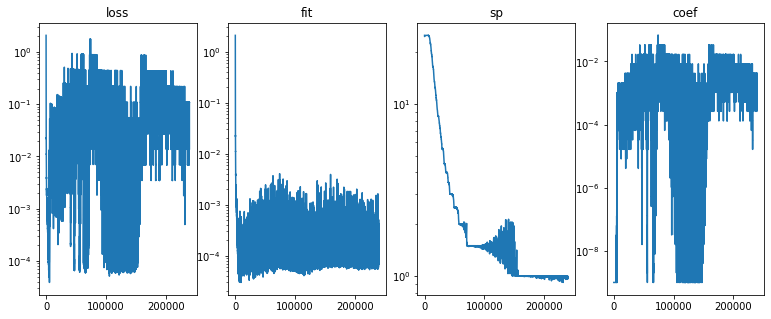

In [498]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 4, 1)
plt.plot(losses)
plt.title('loss')
plt.yscale('log')
plt.subplot(1, 4, 2)
plt.plot(fits)
plt.title('fit')
plt.yscale('log')
plt.subplot(1, 4, 3)
plt.plot(sparsity)
plt.title('sp')
plt.yscale('log')
plt.subplot(1, 4, 4)
plt.plot(coeffs)
plt.title('coef')
plt.yscale('log')

<AxesSubplot:>

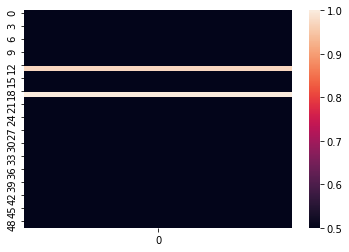

In [499]:
sns.heatmap(sw.probas.detach().cpu().numpy().reshape(-3, 1),
            vmin=0.5, vmax=1)

In [450]:
sw.probas

Parameter containing:
tensor([0.4999, 0.4999, 0.4999, 0.4999, 0.4998, 0.5000, 0.4999, 0.4999, 0.4999,
        0.4999, 0.4999, 0.4999, 0.4999, 1.0000, 0.4999, 0.4999, 0.4999, 0.4998,
        0.4999, 0.9999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.5008,
        0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4998, 1.0001,
        0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999,
        0.5001, 0.4999, 0.4999, 0.4999, 0.4999], device='cuda:0',
       requires_grad=True)